In [1]:
import numpy as np
import argparse
import time
import os
import collections
import json
from scipy import special

from utils.data_utils import load_dataset_numpy

In [15]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument("--dataset_in", default='MNIST',
                    help="dataset to be used")
parser.add_argument("--norm", default='l2',
                    help="norm to be used")
parser.add_argument('--num_samples', type=int, default=None)
parser.add_argument('--n_classes', type=int, default=2)
parser.add_argument('--eps', type=float, default=None)
parser.add_argument('--approx_only', dest='approx_only', action='store_true')
parser.add_argument('--use_test', dest='use_test', action='store_true')
parser.add_argument('--track_hard', dest='track_hard', action='store_true')
parser.add_argument('--new_marking_strat', type=str, default=None)

_StoreAction(option_strings=['--new_marking_strat'], dest='new_marking_strat', nargs=None, const=None, default=None, type=<class 'str'>, choices=None, help=None, metavar=None)

In [3]:
args = parser.parse_args("--dataset_in=MNIST --num_samples=5000".split())

## Function definitions

In [4]:
def acc_fn(Y,Y_pred):
    count_correct = 0.0
    for i in range(len(Y)):
        if Y_pred[i] == Y[i]:
            count_correct += 1
    acc = count_correct/len(Y)
    return acc

### Loading data

In [5]:
train_data, test_data, data_details = load_dataset_numpy(args, data_dir='data',
														training_time=False)
DATA_DIM = data_details['n_channels']*data_details['h_in']*data_details['w_in']

X = []
Y = []
X_te = []
Y_te = []

# Pytorch normalizes tensors (so need manual here!)

for (x,y,_, _, _) in test_data:
    X_te.append(x/255.)
    Y_te.append(y)

for (x,y,_, _, _) in train_data:
    X.append(x/255.)
    Y.append(y)

X = np.array(X)
Y = np.array(Y)
X_te = np.array(X_te)
Y_te = np.array(Y_te)

num_samples = int(len(X)/2)

class_1 = 3
class_2 = 7

X_c1 = X[:num_samples].reshape(num_samples, DATA_DIM)
X_c2 = X[num_samples:].reshape(num_samples, DATA_DIM)
X = X.reshape(2*num_samples, DATA_DIM)
X_te = X_te.reshape(len(X_te), DATA_DIM)

In [6]:
Y[num_samples:]=1
Y[:num_samples]=0

## Fitting Gaussian model

In [7]:
from sklearn import mixture

clf = mixture.GaussianMixture(n_components=2, covariance_type='tied')

In [8]:
clf.fit(X,y)

GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [24]:
X_m,y_m = clf.sample(10)
print(y_m)

[0 0 0 0 1 1 1 1 1 1]


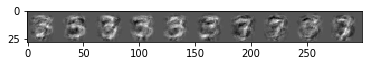

In [23]:
img_array = np.zeros((28,300))
for i in range(10):
    img_array[:,i*30:(i*30+28)] = X_m[i].reshape((28,28))
plt.imshow(img_array,cmap='gray')

### Setup for classification

In [9]:
mu = (clf.means_[0]-clf.means_[1])/2.0
sum_of_means = clf.means_[0]+clf.means_[1]

In [10]:
sigma = clf.covariances_
sigma_inv = clf.precisions_

In [11]:
def predict_linear(w,X):
#     sigma_inv = np.linalg.inv(sigma)
    sigma_inv = clf.precisions_
    b=np.dot(np.dot(sum_of_means,sigma_inv),mu)
#     b=0.5*(np.dot(clf.means_[0],np.dot(sigma_inv,clf.means_[0]))-np.dot(clf.means_[1],np.dot(sigma_inv,clf.means_[1])))
    # sign reversal
    score = np.dot(X,w) - b
    prediction = -1*np.sign(score)
    prediction[prediction==-1] = 0
    return prediction

In [12]:
w_lda = 2*np.dot(sigma_inv,mu)
Y_pred_lda_extract = predict_linear(w_lda, X)
acc_ben_lda_extract = acc_fn(Y,Y_pred_lda_extract)
acc_ben_lda_extract

0.9729

In [13]:
acc_ben = acc_fn(Y,clf.predict(X))
acc_ben

0.9727

## Solving for w

In [27]:
delta_init_1 = np.linspace(0,1,10)
delta_init_2 = np.linspace(1,10,20)
delta_init = np.hstack((delta_init_1,delta_init_2))
rhs_vec=mu
w_opt=[]
eps_opt=[]
for delta in delta_init:
    lhs_mat = 0.5*(sigma+2*delta*np.eye(784))
    w=np.linalg.solve(lhs_mat,rhs_vec)
    eps_curr=delta*np.linalg.norm(w)
    print('Optimal for eps %s' % eps_curr)
    w_opt.append(w)
    eps_opt.append(eps_curr)

Optimal for eps 0.0
Optimal for eps 0.5747755894350147
Optimal for eps 0.8245919751421681
Optimal for eps 1.0018101666831076
Optimal for eps 1.1408423440767552
Optimal for eps 1.2551121096009015
Optimal for eps 1.351612853545571
Optimal for eps 1.4346094476680848
Optimal for eps 1.506961635604225
Optimal for eps 1.5707078110064914
Optimal for eps 1.5707078110064914
Optimal for eps 1.7754655225592906
Optimal for eps 1.9127134800657362
Optimal for eps 2.0113869833169273
Optimal for eps 2.0858297303232205
Optimal for eps 2.144024842863141
Optimal for eps 2.1907838920849882
Optimal for eps 2.2291843928865887
Optimal for eps 2.2612882244919423
Optimal for eps 2.2885294486635614
Optimal for eps 2.311936729428515
Optimal for eps 2.3322673194667667
Optimal for eps 2.3500911379943985
Optimal for eps 2.3658453849628307
Optimal for eps 2.379871084170333
Optimal for eps 2.392438172547857
Optimal for eps 2.4037631191413498
Optimal for eps 2.4140215478239755
Optimal for eps 2.4233574430885616
Optima

### Optimal loss 

In [28]:
optimal_losses = []
for i in range(len(delta_init)):
    alpha = np.dot(w_opt[i],mu)-eps_opt[i]*np.linalg.norm(w_opt[i])
    Q_alpha = 0.5 - 0.5*special.erf(alpha/np.sqrt(2))
    optimal_loss=Q_alpha
    optimal_losses.append(optimal_loss)
    print('Optimal loss at %s is %s' % (eps_opt[i],optimal_loss))

Optimal loss at 0.0 is 0.0
Optimal loss at 0.5747755894350147 is 5.306866057708248e-14
Optimal loss at 0.8245919751421681 is 7.869499601964591e-08
Optimal loss at 1.0018101666831076 is 2.460936456344376e-05
Optimal loss at 1.1408423440767552 is 0.0005072816362269861
Optimal loss at 1.2551121096009015 is 0.0031119113181822255
Optimal loss at 1.351612853545571 is 0.010104312360364576
Optimal loss at 1.4346094476680848 is 0.022680841046501532
Optimal loss at 1.506961635604225 is 0.04046836640398904
Optimal loss at 1.5707078110064914 is 0.062129278402588806
Optimal loss at 1.5707078110064914 is 0.062129278402588806
Optimal loss at 1.7754655225592906 is 0.16591365577423572
Optimal loss at 1.9127134800657362 is 0.25122787660001406
Optimal loss at 2.0113869833169273 is 0.3114153447341434
Optimal loss at 2.0858297303232205 is 0.35331147310579497
Optimal loss at 2.144024842863141 is 0.38306611290038545
Optimal loss at 2.1907838920849882 is 0.404769258522762
Optimal loss at 2.2291843928865887 is

In [29]:
angles = np.zeros((len(delta_init),len(delta_init)))
for i in range(len(delta_init)):
    for j in range(len(delta_init)):
        angles[i,j] = np.dot(w_opt[i],w_opt[j])/(np.linalg.norm(w_opt[i])*np.linalg.norm(w_opt[j]))

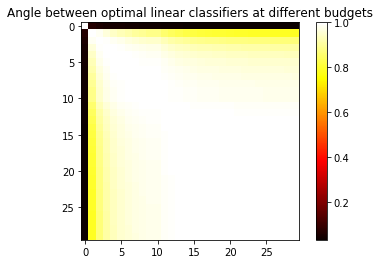

In [35]:
plt.imshow(angles, cmap='hot', interpolation='none')
plt.title('Angle between optimal linear classifiers at different budgets')
plt.colorbar()
plt.show()

### Empirical loss of robust classifier

In [45]:
sign = -1
count = 0
linear_robust_loss = []
for w in w_opt:
    w_curr = w_opt[count]
    eps_curr = eps_opt[count]
    w_curr_unit = w_curr/np.linalg.norm(w_curr)
    X_0_adv = X[:num_samples] - sign*eps_curr*w_curr_unit
    X_1_adv = X[num_samples:] - eps_curr*w_curr_unit
    X_adv = np.vstack((X_0_adv,X_1_adv))
    # w from solving
    Y_pred_adv = predict_linear(w_curr, X_adv)
    acc_curr = acc_fn(Y,Y_pred_adv)
    linear_robust_loss.append(100*acc_curr)
    print('Acc from solved w is %s at eps %s' % (acc_curr,eps_curr))
    count+=1

Acc from solved w is 0.9729 at eps 0.0
Acc from solved w is 0.7733 at eps 0.798514067542972
Acc from solved w is 0.6023 at eps 1.1087731549541655
Acc from solved w is 0.5191 at eps 1.3171972721850091
Acc from solved w is 0.5009 at eps 1.471973796213267
Acc from solved w is 0.5 at eps 1.5927157003116812
Acc from solved w is 0.5 at eps 1.689953841336104
Acc from solved w is 0.5 at eps 1.770109946459857
Acc from solved w is 0.5 at eps 1.837399359374548
Acc from solved w is 0.5 at eps 1.8947298229514442
Acc from solved w is 0.5 at eps 1.944182149078619
Acc from solved w is 0.5 at eps 1.987289036031854
Acc from solved w is 0.5 at eps 2.0252064459666435
Acc from solved w is 0.5 at eps 2.0588236927874286
Acc from solved w is 0.5 at eps 2.0888366924669466
Acc from solved w is 0.5 at eps 2.1157981396843
Acc from solved w is 0.5 at eps 2.1401527352371517
Acc from solved w is 0.5 at eps 2.162262448740031
Acc from solved w is 0.5 at eps 2.1824249750663545
Acc from solved w is 0.5 at eps 2.20088744

### Robustness of clean classifier

In [46]:
w_lda = 2*np.dot(sigma_inv,mu)
w_lda_unit = w_lda/np.linalg.norm(w_lda)

for eps in eps_opt:
    X_0_adv_lda = X[:num_samples] - sign*eps*w_lda_unit
    X_1_adv_lda = X[num_samples:] - eps*w_lda_unit
    X_adv_lda = np.vstack((X_0_adv_lda,X_1_adv_lda))
    # w from lda extract
    Y_pred_adv_lda_extract = predict_linear(w_lda, X_adv_lda)
    acc_curr_lda_extract = acc_fn(Y,Y_pred_adv_lda_extract)
    # LDA
    Y_pred_adv_lda = clf.predict(X_adv_lda)
    acc_curr_lda = acc_fn(Y,Y_pred_adv_lda)
    print('Acc from w extracted is %s at eps %s' % (acc_curr_lda_extract,eps))
    print('Acc from LDA is %s at eps %s' % (acc_curr_lda,eps))

Acc from w extracted is 0.9729 at eps 0.0
Acc from LDA is 0.9727 at eps 0.0
Acc from w extracted is 0.0 at eps 0.798514067542972
Acc from LDA is 0.0 at eps 0.798514067542972
Acc from w extracted is 0.0 at eps 1.1087731549541655
Acc from LDA is 0.0 at eps 1.1087731549541655
Acc from w extracted is 0.0 at eps 1.3171972721850091
Acc from LDA is 0.0 at eps 1.3171972721850091
Acc from w extracted is 0.0 at eps 1.471973796213267
Acc from LDA is 0.0 at eps 1.471973796213267
Acc from w extracted is 0.0 at eps 1.5927157003116812
Acc from LDA is 0.0 at eps 1.5927157003116812
Acc from w extracted is 0.0 at eps 1.689953841336104
Acc from LDA is 0.0 at eps 1.689953841336104
Acc from w extracted is 0.0 at eps 1.770109946459857
Acc from LDA is 0.0 at eps 1.770109946459857
Acc from w extracted is 0.0 at eps 1.837399359374548
Acc from LDA is 0.0 at eps 1.837399359374548
Acc from w extracted is 0.0 at eps 1.8947298229514442
Acc from LDA is 0.0 at eps 1.8947298229514442
Acc from w extracted is 0.0 at eps

### Plotting

NameError: name 'linear_robust_loss' is not defined

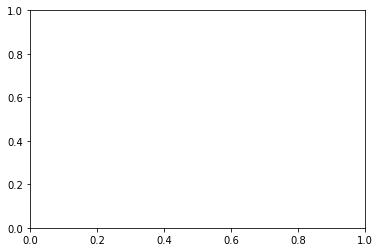

In [36]:


fig, ax = plt.subplots()
ax.plot(eps_opt, linear_robust_loss)

ax.set(xlabel='eps', ylabel='0-1 loss',
       title='Linear classifier loss')
ax.grid()

plt.show()

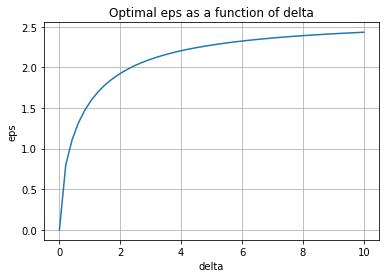

<Figure size 432x288 with 0 Axes>

In [48]:
# Data for plotting

fig, ax = plt.subplots()
ax.plot(delta_init,eps_opt)

ax.set(xlabel='delta', ylabel='eps',
       title='Optimal eps as a function of delta')
ax.grid()

plt.show()
plt.savefig('images/analysis/3_7_fmnist_2000_l2_linear_eps_vs_delta.png')

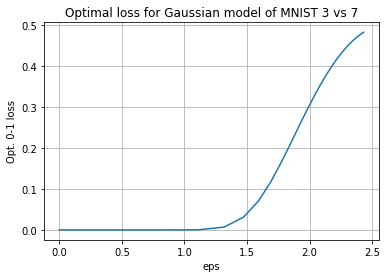

In [38]:
fig, ax = plt.subplots()
ax.plot(eps_opt, optimal_losses)

ax.set(xlabel='eps', ylabel='Opt. 0-1 loss',
       title='Optimal loss for Gaussian model of MNIST 3 vs 7')
ax.grid()

plt.show()

In [49]:
A=np.vstack((eps_opt,linear_robust_loss))

In [50]:
np.savetxt('3_7_2000_fMNIST_l2_linear.txt',A.T, fmt='%2.5f')

In [51]:
np.linalg.norm(mu)

2.6218190308363516

In [52]:
cos_angle = np.dot(mu,w_lda)/(np.linalg.norm(mu)*np.linalg.norm(w_lda))
angle = np.arccos(cos_angle)
angle

1.5395313582523549

In [53]:
cos_angle = np.dot(mu,w_opt[1])/(np.linalg.norm(mu)*np.linalg.norm(w_opt[1]))
angle = np.arccos(cos_angle)
angle

0.5624581139262999

In [54]:
eps=3.6
kappa_init = [4,2,1,0.5,0.25]
rhs_vec=mu
w_opt_1=[]
for kappa in kappa_init:
    print(kappa)
    lhs_mat = 0.5*(1/kappa)*(kappa*sigma+2*eps*np.eye(784))
    w=np.linalg.solve(lhs_mat,rhs_vec)
    print(np.linalg.norm(w))
    if abs(kappa-np.linalg.norm(w))<0.05:
        w_opt_1.append(w)

4
1.6818834695017402
2
1.0417184141321258
1
0.6022479908375248
0.5
0.32877190320173966
0.25
0.172644755219775


In [55]:
from scipy import special

count = 0
for eps in eps_opt:
    w = w_opt[count]
    first = np.dot(sigma,w)
    second = np.dot(w,first)
    alpha_curr = 0.5*(np.sqrt(second))
    print(alpha_curr)
    min_loss = 1-special.ndtr(alpha_curr)
    print('min. loss. is %s at %s' % (min_loss, eps))
    count += 1

3.223236626767366
min. loss. is 0.000633753997339892 at 0.0
1.649301828459808
min. loss. is 0.04954290762843683 at 0.798514067542972
1.3141713609672656
min. loss. is 0.094394271923806 at 1.1087731549541655
1.110122192086034
min. loss. is 0.13347318774591932 at 1.3171972721850091
0.9660182460332953
min. loss. is 0.1670175255000771 at 1.471973796213267
0.8570082023405088
min. loss. is 0.1957201757743845 at 1.5927157003116812
0.7710277545324702
min. loss. is 0.2203452403761843 at 1.689953841336104
0.701210604857668
min. loss. is 0.2415857963114113 at 1.770109946459857
0.643264797955555
min. loss. is 0.26002614692675596 at 1.837399359374548
0.5943343384355818
min. loss. is 0.276144258013139 at 1.8947298229514442
0.5524305345062345
min. loss. is 0.2903267076202457 at 1.944182149078619
0.5161194919214253
min. loss. is 0.30288547748428074 at 1.987289036031854
0.48433809718101073
min. loss. is 0.3140729713639866 at 2.0252064459666435
0.4562798116543259
min. loss. is 0.32409438969991355 at 2.05